In [2]:
import sys
import os
import numpy as np
import pandas as pd
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import networkx as nx
from sklearn import preprocessing
import selenium
import geopandas as gp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy
from scipy.stats import norm

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)

# local functions
import matrix_operation
import diffusionNMF
import grid_search
import nmf
from matrix_operation import mat_opr
from diffusionNMF import diffusionNMF
from grid_search import gridSearcher
from nmf import nmf

%load_ext autoreload
%autoreload 2

In [8]:
#sns.set_palette("Paired")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 1
c_pal = sns.color_palette("colorblind", 10)

In [9]:
from collections import OrderedDict

linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

In [10]:
def rescale(X,V,K = None):
    X = copy.deepcopy(X)
    V = copy.deepcopy(V)

    maxer = np.amax(X)
    X /= maxer
    V *= maxer
    
    return X,V

In [11]:
# adjacency Laplacian
state_dset = pd.read_csv(os.path.join(par, 'collected_data/state_dataset.csv'), index_col = 0)
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0)
# json file with geographic info for each state -- required for graphing
state_map = os.path.join(par, 'collected_data/US_States_geojson.json')

In [12]:
state_L = state_L.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 1)
state_L = state_L.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 0)
state_L = state_L.to_numpy()

state_dset = state_dset.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 1)

In [13]:
my_pal = sns.choose_cubehelix_palette(as_cmap = True)

interactive(children=(IntSlider(value=9, description='n_colors', max=16, min=2), FloatSlider(value=0.0, descri…

In [14]:

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mpl.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [15]:
#h_list = ["720026","ce4257","ff7f51","ff9b54"] #"4f000b"
#h_list = ["aa1b21","b7261c","c43117","d0431c","db5421","ec7431","fd9340","fea75d","ffba79","ffd29d"]
h_list = ["ffb950","ffad33","ff931f","ff7e33","fa5e1f","ec3f13","b81702","a50104","8e0103","7a0103"]
my_pal = get_continuous_cmap(h_list)

# Intro

In [10]:
frame = np.arange(0,100,1)
introX = norm.pdf(frame, 50, 10)

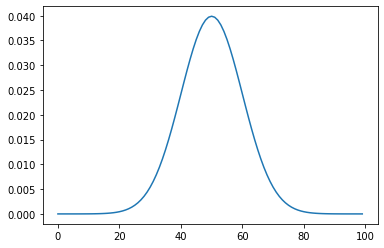

In [11]:
# normal bell curve for wave of X
plt.plot(frame,introX)

In [15]:
# Corresponding simple V with only New York set to 1 (New york is origin point)
introV = np.zeros(len(state_dset.columns))
introV[state_dset.columns.get_loc("New York")] = 1
introV[state_dset.columns.get_loc("West Virginia")] = 1
introV = pd.Series(introV, index = state_dset.columns)

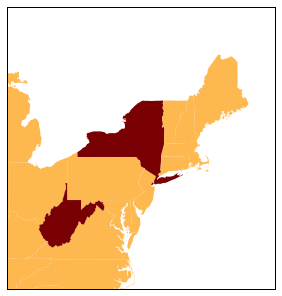

In [182]:
stateMap = gp.read_file(state_map)

val_col = []

for i in stateMap["NAME"]:
    try:
        val_col.append(introV[i])
    except:
        val_col.append(np.nan)

stateMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

stateMap.plot(column='val',legend=False, ax = ax, cmap=my_pal)
ax.set_xlim(-85, -65)
ax.set_ylim(35, 50)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

In [27]:
introK = np.linalg.inv(np.identity(len(state_L)) + 50 * state_L)
introK = preprocessing.MinMaxScaler().fit_transform(introK)
diffuse = pd.DataFrame(introK, columns = state_dsetcolumns, index = state_dset.dataframe.columns)

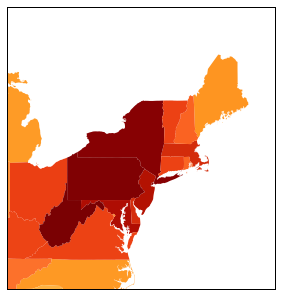

In [183]:
val_col = []

for i in stateMap["NAME"]:
    try:
        val_col.append(diffuse.loc["New York", i] + diffuse.loc["West Virginia", i])
    except:
        val_col.append(np.nan)

stateMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

stateMap.plot(column='val',legend=False, ax = ax, cmap=my_pal)
ax.set_xlim(-85, -65)
ax.set_ylim(35, 50)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

In [137]:
intro_data = np.dot([[i] for i in introX], np.dot([introV], introK))

#### NMF intro

In [54]:
nmfer = nmf(1, n_iter = 100000, tol = 1e-9)
iW,iH = nmfer.fit_transform(intro_data)

In [56]:
iW,iH = rescale(iW,iH)
iW = pd.DataFrame(iW)
iH = pd.DataFrame(iH, columns = state_dset.columns)

<AxesSubplot:>

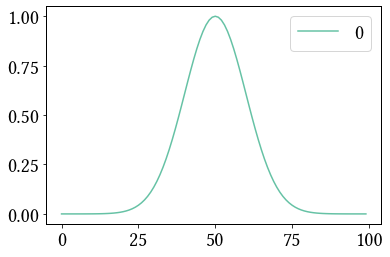

In [60]:
iW.plot()

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


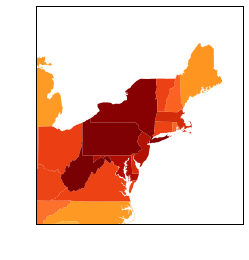

In [502]:
val_col = []

for i in stateMap["NAME"]:
    try:
        val_col.append(iH.loc[0, i])
    except:
        val_col.append(np.nan)

stateMap['val'] = val_col

fig,ax = plt.subplots(1,1, figsize = (8,4))

stateMap.plot(column='val',legend=False, ax = ax, cmap=my_pal)
ax.set_xlim(-85, -65)
ax.set_ylim(35, 50)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_xlabel(" ")
ax.set_ylabel(" ")
fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/nmf_example.pdf', bbox_inches = "tight")

In [388]:
iH.loc[0,'Pennsylvania']

0.05444398890702223

In [389]:
iH.loc[0,'New York']

0.052610498823930776

In [390]:
iH.loc[0,'West Virginia']

0.05632504544427803

#### D-NMf

In [62]:
dNMF = diffusionNMF(n_components = 1, kernel = introK, n_iter = 100000  , tol = 1e-9)
iX,iV = dNMF.fit_transform(intro_data)

In [64]:
iX,iV = rescale(iX,iV)
iX = pd.DataFrame(iX)
iV = pd.DataFrame(iV, columns = state_dset.columns)

<AxesSubplot:>

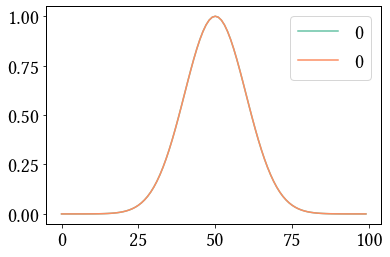

In [65]:
fig,ax = plt.subplots(1,1)
iX.plot(ax = ax)
iW.plot(ax = ax)

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


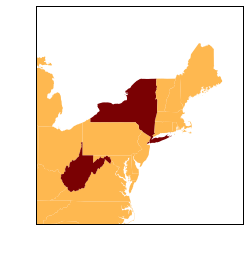

In [503]:
val_col = []

for i in stateMap["NAME"]:
    try:
        val_col.append(iV.loc[0, i])
    except:
        val_col.append(np.nan)

stateMap['val'] = val_col

fig,ax = plt.subplots(1,1, figsize = (8,4))

stateMap.plot(column='val',legend=False, ax = ax, cmap=my_pal)
ax.set_xlim(-85, -65)
ax.set_ylim(35, 50)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_xlabel(" ")
ax.set_ylabel(" ")
fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/dnmf_example.pdf', bbox_inches = "tight")

In [7]:
K1 = np.linalg.inv(np.identity(len(state_L)) + 0.01 * state_L)
k1s = preprocessing.MinMaxScaler().fit_transform(K1)
diffuse1 = pd.DataFrame(k1s, columns = state_dset.columns, index = state_dset.columns)

K2 = np.linalg.inv(np.identity(len(state_L)) + 10 * state_L)
k2s = preprocessing.MinMaxScaler().fit_transform(K2)
diffuse2 = pd.DataFrame(k2s, columns = state_dset.columns, index = state_dset.columns)

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


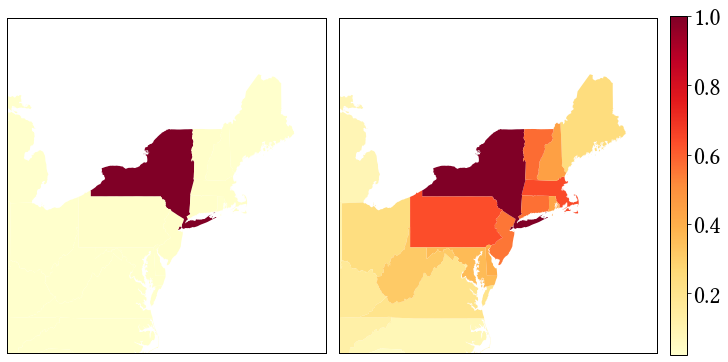

In [12]:
stateMap = gp.read_file(state_map)

val_col1 = []
val_col2 = []

for i in stateMap["NAME"]:
    try:
        val_col1.append(diffuse1.loc["New York",i])
    except:
        val_col1.append(np.nan)
for i in stateMap["NAME"]:
    try:
        val_col2.append(diffuse2.loc["New York",i])
    except:
        val_col2.append(np.nan)

stateMap['val1'] = val_col1
stateMap['val2'] = val_col2

fig,ax = plt.subplots(1,2, constrained_layout=True, figsize = (10,5))
#divider = make_axes_locatable(ax[2])
#cax = divider.append_axes("right", size="2%", pad=-0.2)

stateMap.plot(column='val1',legend=False, ax = ax[0], cmap='YlOrRd')
ax[0].set_xlim(-85, -65)
ax[0].set_ylim(35, 50)
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[0].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax[0].set_title("Before Diffusion")

stateMap.plot(column='val2',legend=True, ax = ax[1], cmap='YlOrRd', legend_kwds={'shrink': 0.95, 'aspect': 40})
ax[1].set_xlim(-85, -65)
ax[1].set_ylim(35, 50)
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax[1].set_title("After Diffusion")

#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/diff_example.pdf')

In [99]:
sns.set_palette("Oranges")

In [ ]:
h_list = ["ffb950","ffad33","ff931f","ff7e33","fa5e1f","ec3f13","b81702","a50104","8e0103","7a0103"]

In [187]:
intr = pd.DataFrame(intro_data, columns = state_dset.columns)

In [207]:
vv = intr.max()/(intr.max().max())

color_dict = {col:my_pal(vv[col]) for col in intr.columns}
color_dict["West Virginia"] = my_pal(0.99)

(0.99609375, 0.72265625, 0.3125, 1.0)

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


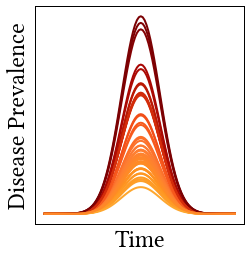

In [493]:
fig,ax = plt.subplots(1,1, figsize = (3.75,4))
intr.plot(ax = ax, legend = False, linewidth = 2, color = [color_dict[x] for x in intr.columns])
ax.set_ylabel("Disease Prevalence")
ax.set_xlabel("Time")
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/wave_example.pdf', bbox_inches = "tight")

In [205]:
vv = intr.max()/(intr.max().max())

0.2647113498768023

### State Figures

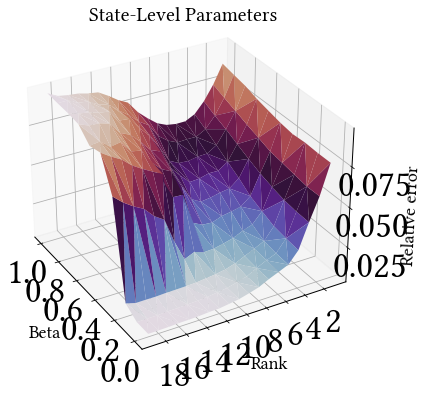

In [291]:
state_grid = pd.read_csv("./testing_data/state_grid_search_adj2.csv")
fig = plt.figure(figsize = (10,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(state_grid['beta'], state_grid['rank'], state_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

ax.xaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
#ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
#ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("State-Level Parameters", fontsize = 20)
ax.view_init(30,150)
ax.dist = 9

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_grid.pdf')

In [292]:
state_grid

,rank,beta,relative error,std error
0,1,0.000000,0.075884,0.000928
1,1,0.111111,0.075920,0.001094
2,1,0.222222,0.076405,0.001064
3,1,0.333333,0.075899,0.000985
4,1,0.444444,0.077143,0.000565
...,...,...,...,...
185,19,0.555556,0.087211,0.003454
186,19,0.666667,0.094316,0.003783
187,19,0.777778,0.095382,0.003398
188,19,0.888889,0.095736,0.003365


In [45]:
smallest_indices = np.argsort(np.diag(state_L))[:10]
smallest = state_dset.columns[smallest_indices]
print("Average node degree: " + str(np.average(np.diag(state_L))))

Average node degree: 4.448979591836735


Text(0.5, 1.0, '10 Smallest degree nodes')

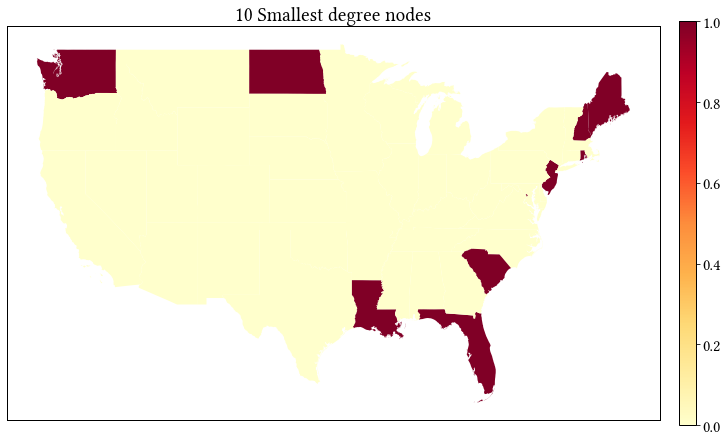

In [49]:
stateMap = gp.read_file(state_map)
val_col = []

for i in stateMap["NAME"]:
    if i in smallest:
        val_col.append(1)
    elif i in state_dset.columns:
        val_col.append(0)
    else:
        val_col.append(np.nan)

stateMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (10,6))
stateMap.plot(column='val', legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.950, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("10 Smallest degree nodes")

In [64]:
K = np.linalg.inv(np.identity(len(state_L)) + 0.2 * state_L)

In [242]:
# population data
population = pd.read_csv(os.path.join(par, 'collected_data/state_census_estimate.csv'), index_col = 'NAME')
state_dset = mat_opr(state_dset)
# clean + normalize
state_iso = state_dset.iso()
pop_dict = {}
for col in state_iso.dataframe.columns:
    pop_dict[col] = population.loc[col,'POP']
    
state_norm = state_iso.population_normalizer(pop_dict)

In [7]:
errs = []
for r in range(1,20):
    nmfer = nmf(r, n_iter = 100000, tol = 1e-9)
    W,H = nmfer.fit_transform(state_norm.dataframe)
    err = np.linalg.norm(state_norm.dataframe - np.dot(W,H))/np.linalg.norm(state_norm.dataframe)
    errs.append(err)

Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance


In [8]:
errs = pd.DataFrame(errs)
errs.to_csv("./testing_data/nmf_rank_errors.csv")

In [9]:
errs = pd.read_csv("./testing_data/nmf_rank_errors.csv", index_col = 0)

In [10]:
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


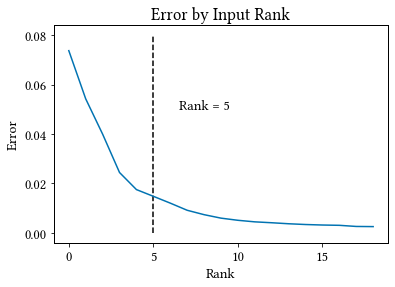

In [12]:
errs.plot(legend = False)
plt.xticks([0,5,10,15,20])
plt.yticks([0,0.02,0.04,0.06,0.08])
plt.vlines(x = 5, ymin = -0.0001, ymax = 0.08, colors = 'k', linestyles = '--', label = "rank = 6")
plt.ylabel("Error")
plt.xlabel("Rank")
plt.title("Error by Input Rank")
#plt.legend()
plt.text(6.5,0.05,"Rank = 5")
plt.savefig("test_fig.pdf")

In [243]:
rank = 5
beta = 1
K = np.linalg.inv(np.identity(len(state_L)) + beta * state_L)
dNMF = diffusionNMF(n_components = rank, kernel = K, n_iter = 200000  , tol = 1e-10)
X,V = dNMF.fit_transform(state_norm.dataframe)

In [244]:
X,V = rescale(X,V,K)
X = pd.DataFrame(X, index = state_norm.dataframe.index)
V = pd.DataFrame(V, columns = state_norm.dataframe.columns)

In [245]:
nmfer = nmf(rank, n_iter = 200000, tol = 1e-10)
W,H = nmfer.fit_transform(state_norm.dataframe)

Max iterations reached, increase to converge on given tolerance


In [246]:
W,H = rescale(W,H)
W = pd.DataFrame(W, index = state_norm.dataframe.index)
H = pd.DataFrame(H, columns = state_norm.dataframe.columns)

In [247]:
diff_error = np.linalg.norm(state_norm.dataframe - np.dot(X, np.dot(V, K)))/np.linalg.norm(state_norm.dataframe)
nmf_error = np.linalg.norm(state_norm.dataframe - np.dot(W, H))/np.linalg.norm(state_norm.dataframe)

print("Diffusion NMF error: " + str(diff_error))
print("NMF error: " + str(nmf_error))

Diffusion NMF error: 0.05270451929986373
NMF error: 0.017441885594375896


In [249]:
# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [2,0,3,4,1]
X = X[reorder]
X.columns = standard
V = V.reindex(reorder)
V.index = standard 

In [5]:
#X.to_csv("./testing_data/state_X.csv")
#V.to_csv("./testing_data/state_V.csv")

X = pd.read_csv("./testing_data/state_X.csv", index_col = 0)
V = pd.read_csv("./testing_data/state_V.csv", index_col = 0)
X.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]

In [7]:
sns.set_palette("Set2")

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


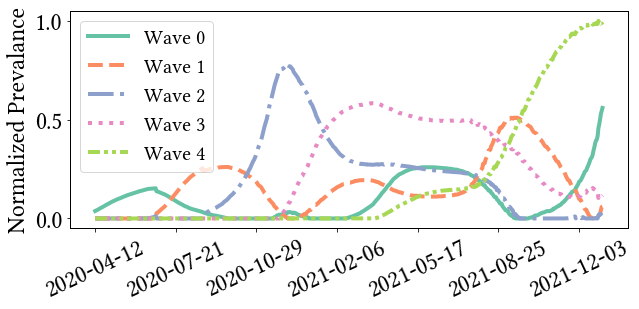

In [24]:
plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 20
X.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(X.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()
#X.plot(figsize = (10,5))
plt.xticks(rotation = 25)
#plt.xlabel("Date")
plt.ylabel("Normalized Prevalance")
#plt.title("State Wide Diffusion NMF Columns of X")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_diffX.pdf',  bbox_inches = "tight")
plt.show()

In [254]:
# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [0,4,3,2,1]
W = W[reorder]
W.columns = standard
H = H.reindex(reorder)
H.index = standard 

In [25]:
#W.to_csv("./testing_data/state_W.csv")
#H.to_csv("./testing_data/state_H.csv")

W = pd.read_csv("./testing_data/state_W.csv", index_col = 0)
H = pd.read_csv("./testing_data/state_H.csv", index_col = 0)
W.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


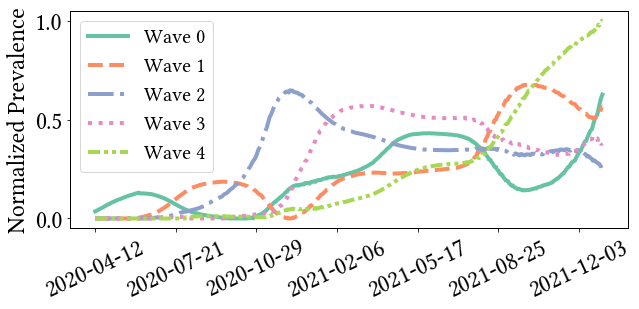

In [94]:
plt.rcParams["font.size"] = 24
W.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(W.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()

#W.plot(figsize = (10,5))
plt.xticks(rotation = 25)
#plt.xlabel("Date")
plt.ylabel("Normalized Prevalence")
#plt.title("State Wide NMF Columns of W")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper2/figures/state_nmfX.pdf',  bbox_inches = "tight")
plt.show()

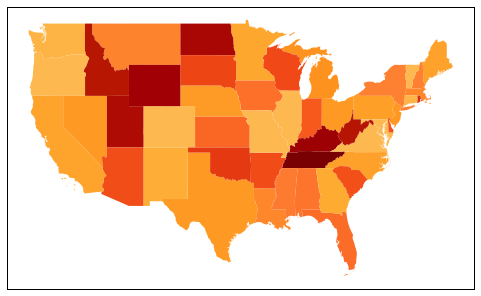

In [270]:
plt.rcParams["font.size"] = 36
stateMap = gp.read_file(state_map)
#VK = V@K
#VK.columns = V.columns
row_num = 4

val_col1 = []
val_col2 = []
for i in stateMap["NAME"]:
    try:
        val_col1.append(V.loc[row_num,i])
    except:
        pass
        val_col1.append(np.nan)

'''
for i in stateMap["NAME"]:
    try:
        val_col2.append(VK.loc[row_num,i])
    except:
        val_col2.append(np.nan)
'''

stateMap['val1'] = val_col1
#stateMap['val2'] = val_col2

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

stateMap.plot(column='val1',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

'''
stateMap.plot(column='val2',legend=True, ax = ax[1], cmap='YlOrRd', legend_kwds={'shrink': 0.50, 'aspect': 40})
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax[1].set_title("Row " + str(row_num) + " of VK")
'''

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_V' + str(row_num) + '.pdf', bbox_inches = "tight")

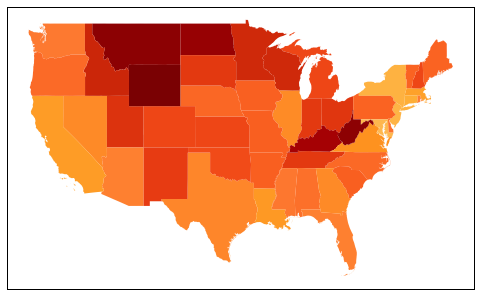

In [276]:
row_num = 4

H_col = []
for i in stateMap["NAME"]:
    try:
        H_col.append(H.loc[row_num,i])
    except:
        H_col.append(np.nan)

stateMap['val'] = H_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))
stateMap.plot(column='val',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax.set_title("Row " + str(row_num) + " of H")

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_H' + str(row_num) + '.pdf', bbox_inches = "tight")

In [89]:
state_diff_error = pd.read_csv("./testing_data/state_diff_error2.csv", index_col = 0)
state_nmf_error = pd.read_csv("./testing_data/state_nmf_error2.csv", index_col = 0)

In [54]:
plt.rcParams['legend.fontsize'] = 24

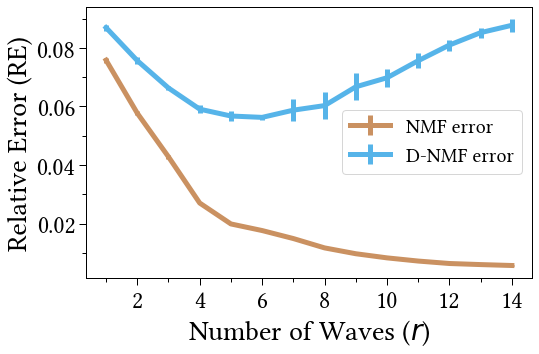

In [90]:
ranks = list(range(1,15))
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(ranks, state_nmf_error["relative error"], state_nmf_error["std error"], label = "NMF error", linewidth = 5, color = c_pal[5])
ax.errorbar(ranks, state_diff_error["relative error"], state_diff_error["std error"], label = "D-NMF error", linewidth = 5, color = c_pal[9])

ax.set_xlabel(r"Number of Waves ($r$)", fontsize = 28)
ax.set_ylabel("Relative Error (RE)", fontsize = 28)
plt.legend()
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_error.pdf', bbox_inches = "tight")

## Counties

In [281]:
# geo json map
county_map = os.path.join(par, 'collected_data/US_counties_geo.json')

# county laplacian
countyLaplacian = pd.read_csv(os.path.join(par, "collected_data/countyLaplacian.csv"), index_col = 0)
countyLaplacian.columns = countyLaplacian.columns.astype("int")

# county census data for normalization
county_pop = pd.read_csv(os.path.join(par, "collected_data/county_census.csv"), index_col = "fips")

### New England

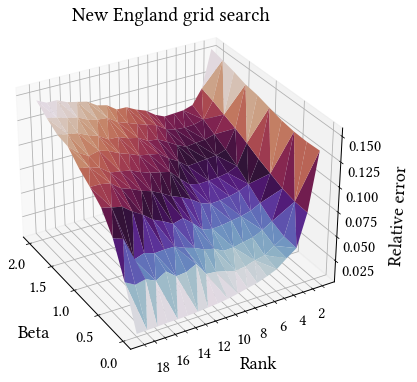

In [106]:
new_eng_grid = pd.read_csv("./testing_data/new_eng_grid2.csv")
fig = plt.figure(figsize = (14,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(new_eng_grid['beta'], new_eng_grid['rank'], new_eng_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)

ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("New England grid search")
ax.view_init(30,150)
ax.dist = 9

#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/grid_newEng.pdf',  bbox_inches = "tight")

In [282]:
new_eng = pd.read_csv(os.path.join(par, 'collected_data/county_dataset.csv'), index_col = [0,1,2])
new_eng = new_eng.loc[new_eng.index.get_level_values("state").isin(["New York", "Connecticut", "Maine", "Vermont",
                                                       "Massachusetts", "New Hampshire", "Rhode Island"])]
new_eng.index = new_eng.index.get_level_values("fips")
new_eng = new_eng.T

ne_lapl = countyLaplacian.loc[new_eng.columns,new_eng.columns].to_numpy()
ne_pop = county_pop.loc[new_eng.columns, :]

ne_map = os.path.join(par, 'collected_data/new_eng_counties_geo.json')

In [108]:
smallest_indices = np.argsort(np.diag(ne_lapl))[:10]
smallest = new_eng.columns[smallest_indices]
print("Average node degree: " + str(np.average(np.diag(ne_lapl))))

Average node degree: 5.3858267716535435


Text(0.5, 1.0, '10 Smallest degree nodes')

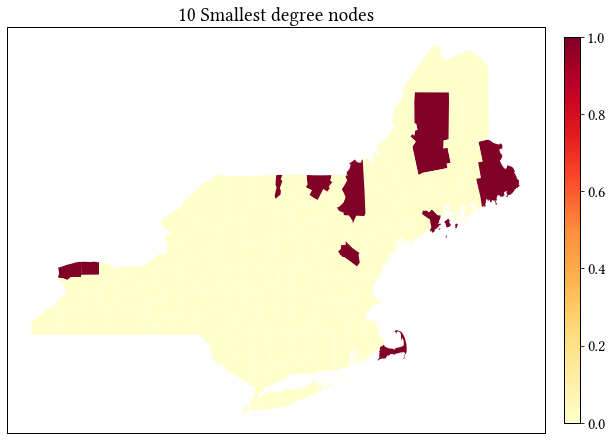

In [109]:
newEngMap = gp.read_file(ne_map)
val_col = []

for i in newEngMap["id"]:
    if int(i) in smallest:
        val_col.append(1)
    else:
        val_col.append(0)

newEngMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (10,6))
newEngMap.plot(column='val', legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.950, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("10 Smallest degree nodes")

In [110]:
# clean + normalize
new_eng_dset = mat_opr(new_eng)
new_eng_iso = new_eng_dset.iso()
pop_dict = {}
for col in new_eng_iso.dataframe.columns:
    pop_dict[col] = ne_pop.loc[col,'Population Estimate']        
    
new_eng_norm = new_eng_iso.population_normalizer(pop_dict)

In [114]:
rank = 5
beta = 1
neK = np.linalg.inv(np.identity(len(ne_lapl)) + beta * ne_lapl)
dNMF = diffusionNMF(n_components = rank, kernel = neK, n_iter = 1000000, tol = 1e-10)
neX,neV = dNMF.fit_transform(new_eng_norm.dataframe)

In [115]:
neX,neV = rescale(neX,neV,neK)
neX = pd.DataFrame(neX, index = new_eng_norm.dataframe.index)
neV = pd.DataFrame(neV, columns = new_eng_norm.dataframe.columns)

In [117]:
nmfer = nmf(rank, n_iter = 1000000, tol = 1e-10)
neW,neH  = nmfer.fit_transform(new_eng_norm.dataframe)

In [118]:
neW,neH = rescale(neW,neH)
neW = pd.DataFrame(neW, index = new_eng_norm.dataframe.index)
neH = pd.DataFrame(neH, columns = new_eng_norm.dataframe.columns)

In [120]:
ne_diff_error = np.linalg.norm(new_eng_norm.dataframe - np.dot(neX, np.dot(neV, neK)))/np.linalg.norm(new_eng_norm.dataframe)
ne_nmf_error = np.linalg.norm(new_eng_norm.dataframe - np.dot(neW, neH))/np.linalg.norm(new_eng_norm.dataframe)

print("Diffusion NMF error: " + str(ne_diff_error))
print("NMF error: " + str(ne_nmf_error))

Diffusion NMF error: 0.061634155042311026
NMF error: 0.02309831360858838


In [123]:
# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [1,3,0,2,4]
neX = neX[reorder]
neX.columns = standard
neV = neV.reindex(reorder)
neV.index = standard 

In [27]:
#neX.to_csv("./testing_data/new_england_X.csv")
#neV.to_csv("./testing_data/new_england_V.csv")

neX = pd.read_csv("./testing_data/new_england_X.csv", index_col = 0)
neV = pd.read_csv("./testing_data/new_england_V.csv", index_col = 0)
neV.columns = neV.columns.astype(int)

In [296]:
sns.set_palette("husl")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.linewidth'] = 1

In [28]:
neX.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


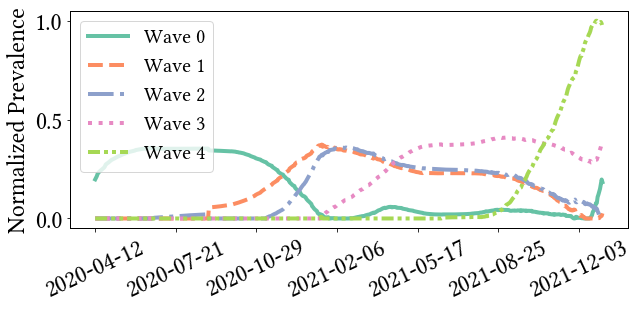

In [29]:
neX.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(neX.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()
plt.xticks(rotation = 25)
#plt.xlabel("Date")
plt.ylabel("Normalized Prevalence")
#plt.title("New England Counties Diffusion NMF Columns of X")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_diffX.pdf',  bbox_inches = "tight")
plt.show()

In [131]:
# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [2,4,1,0,3]
neW = neW[reorder]
neW.columns = standard
neH = neH.reindex(reorder)
neH.index = standard 

In [30]:
#neW.to_csv("./testing_data/new_england_W.csv")
#neH.to_csv("./testing_data/new_england_H.csv")

neW = pd.read_csv("./testing_data/new_england_W.csv", index_col = 0)
neH = pd.read_csv("./testing_data/new_england_H.csv", index_col = 0)
neH.columns = neH.columns.astype(int)
neW.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


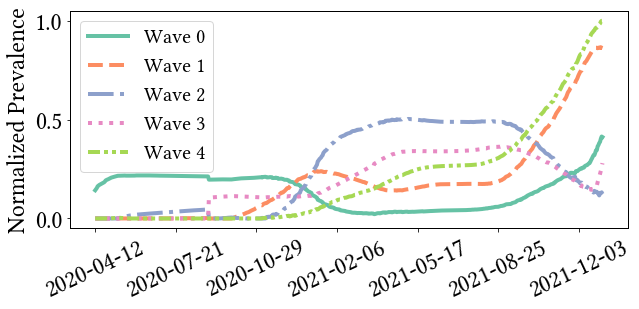

In [31]:
neW.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(neW.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()
plt.xticks(rotation = 25)
#plt.xlabel("Date")
plt.ylabel("Normalized Prevalence")
#plt.title("New England Counties NMF Columns of W")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_nmfX.pdf',  bbox_inches = "tight")
plt.show()

In [71]:
plt.rcParams['font.size'] = 36

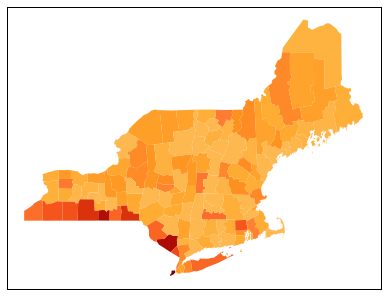

In [307]:
newEngMap = gp.read_file(ne_map)
#neVK = neV@neK
#neVK.columns = neV.columns
row_num = 4

val_col1 = []
val_col2 = []
for i in newEngMap["id"]:
    try:
        val_col1.append(neV.loc[row_num,int(i)])
    except:
        val_col1.append(np.nan)
'''
for i in newEngMap["id"]:
    try:
        val_col2.append(neVK.loc[row_num,int(i)])
    except:
        val_col2.append(np.nan)
'''
newEngMap['val1'] = val_col1
#newEngMap['val2'] = val_col2

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

newEngMap.plot(column='val1',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax.set_title("Row " + str(row_num) + " of V")

'''
newEngMap.plot(column='val2',legend=True, ax = ax[1], cmap='YlOrRd', legend_kwds={'shrink': 0.60, 'aspect': 40})
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax[1].set_title("Row " + str(row_num) + " of VK")
'''

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_V' + str(row_num) + '.pdf', bbox_inches = "tight")

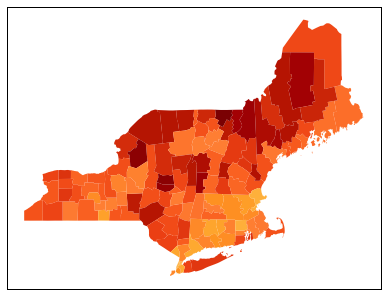

In [312]:
newEngMap = gp.read_file(ne_map)
val_col = []
row_num = 4
for i in newEngMap["id"]:
    try:
        val_col.append(neH.loc[row_num,int(i)])
    except:
        val_col.append(np.nan)

newEngMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))
newEngMap.plot(column='val', legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax.set_title("Row " + str(row_num) + " of H")

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_H' + str(row_num) + '.pdf', bbox_inches = "tight")

In [47]:
newEng_diff_error = pd.read_csv("./testing_data/newEng_diff.csv", index_col = 0)
newEng_nmf_error = pd.read_csv("./testing_data/newEng_nmf.csv", index_col = 0)

In [457]:
plt.rcParams['legend.fontsize'] = 20

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


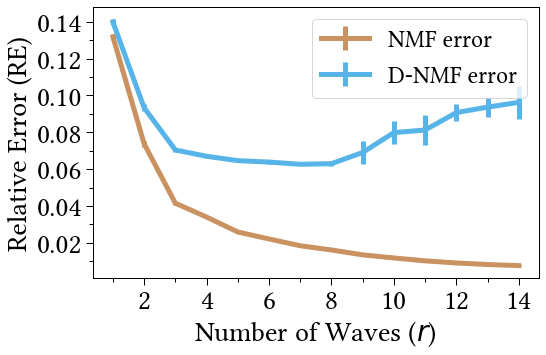

In [56]:
ranks = list(range(1,15))
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(ranks, newEng_nmf_error["relative error"], newEng_nmf_error["std error"], label = "NMF error", linewidth = 5, color = c_pal[5])
ax.errorbar(ranks, newEng_diff_error["relative error"], newEng_diff_error["std error"], label = "D-NMF error", linewidth = 5, color = c_pal[9])

ax.set_xlabel(r"Number of Waves ($r$)", fontsize = 28)
ax.set_ylabel("Relative Error (RE)", fontsize = 28)
plt.legend()
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_error.pdf', bbox_inches = "tight")

### California

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


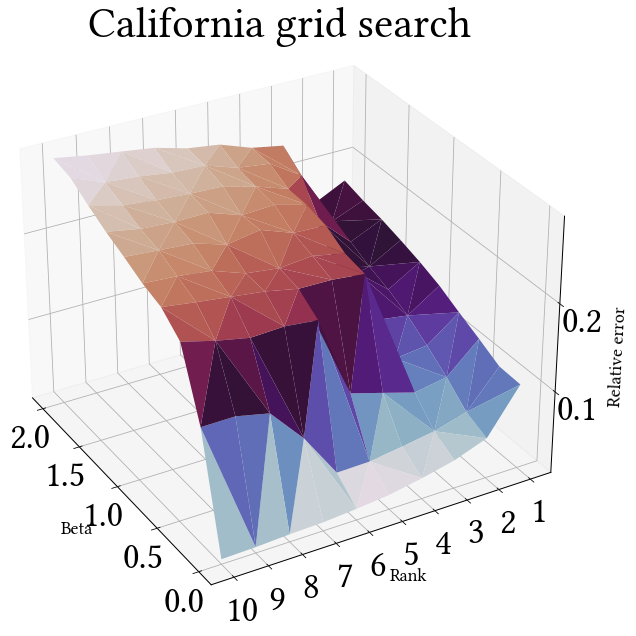

In [365]:
cali_grid = pd.read_csv("./testing_data/california_grid2.csv")
cali_grid = cali_grid[cali_grid["rank"] <= 10]
cali_grid = cali_grid.loc[cali_grid["beta"] <= 3]
fig = plt.figure(figsize = (14,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(cali_grid['beta'], cali_grid['rank'], cali_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)

ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("California grid search")
ax.view_init(30,150)
ax.dist = 9

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/grid_california.pdf')

In [366]:
cali_grid

,rank,beta,relative error,std error
0,1,0.000000,0.103033,0.000942
1,1,0.222222,0.104261,0.001402
2,1,0.444444,0.116982,0.001279
3,1,0.666667,0.128890,0.001621
4,1,0.888889,0.141599,0.001106
...,...,...,...,...
95,10,1.111111,0.250312,0.010844
96,10,1.333333,0.260093,0.012172
97,10,1.555556,0.271895,0.013131
98,10,1.777778,0.285247,0.011906


In [319]:
cali = pd.read_csv(os.path.join(par, 'collected_data/county_dataset.csv'), index_col = [0,1,2])
cali = cali.loc[cali.index.get_level_values("state").isin(["California"])]
cali.index = cali.index.get_level_values("fips")
cali = cali.T

cali_lapl = countyLaplacian.loc[cali.columns,cali.columns].to_numpy()
cali_pop = county_pop.loc[cali.columns, :]
cali_map = os.path.join(par, 'collected_data/cali_counties_geo.json')

In [173]:
smallest_indices = np.argsort(np.diag(cali_lapl))[:10]
smallest = cali.columns[smallest_indices]
print("Average node degree: " + str(np.average(np.diag(cali_lapl))))

Average node degree: 5.4655172413793105


In [174]:
np.diag(cali_lapl)[smallest_indices]

array([3., 3., 3., 4., 4., 4., 4., 4., 4., 4.])

Text(0.5, 1.0, '10 Smallest degree nodes')

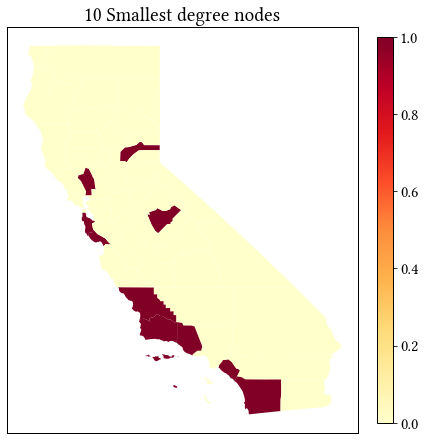

In [175]:
caliMap = gp.read_file(cali_map)
val_col = []

for i in caliMap["id"]:
    if int(i) in smallest:
        val_col.append(1)
    else:
        val_col.append(0)

caliMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (10,6))
caliMap.plot(column='val', legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.950, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("10 Smallest degree nodes")

In [345]:
# clean + normalize
cali_dset = mat_opr(cali)
cali_iso = cali_dset.iso()
pop_dict = {}
for col in cali_iso.dataframe.columns:
    pop_dict[col] = cali_pop.loc[col,'Population Estimate']        
    
cali_norm = cali_iso.population_normalizer(pop_dict)

In [387]:
rank = 3
beta = 1
cK = np.linalg.inv(np.identity(len(cali_lapl)) + beta * cali_lapl)
dNMF = diffusionNMF(n_components = rank, kernel = cK, n_iter = 1000000, tol = 1e-10)
cX,cV = dNMF.fit_transform(cali_norm.dataframe)

In [388]:
cX,cV = rescale(cX,cV,cK)
cX = pd.DataFrame(cX, index = cali_norm.dataframe.index)
cV = pd.DataFrame(cV, columns = cali_norm.dataframe.columns)

In [389]:
nmfer = nmf(rank, n_iter = 1000000, tol = 1e-10)
cW,cH = nmfer.fit_transform(cali_norm.dataframe)

In [390]:
cW,cH = rescale(cW,cH)
cW = pd.DataFrame(cW, index = cali_norm.dataframe.index)
cH = pd.DataFrame(cH, columns = cali_norm.dataframe.columns)

In [350]:
cali_diff_error = np.linalg.norm(cali_norm.dataframe - np.dot(cX, np.dot(cV, cK)))/np.linalg.norm(cali_norm.dataframe)
cali_nmf_error = np.linalg.norm(cali_norm.dataframe - np.dot(cW, cH))/np.linalg.norm(cali_norm.dataframe)

print("Diffusion NMF error: " + str(cali_diff_error))
print("NMF error: " + str(cali_nmf_error))

Diffusion NMF error: 0.11384672948399463
NMF error: 0.03311426884666868


In [392]:
# RE-order for better presentation
standard = [0,1,2]
reorder = [1,2,0]
cX = cX[reorder]
cX.columns = standard
cV = cV.reindex(reorder)
cV.index = standard 

In [32]:
#cX.to_csv("./testing_data/california_X.csv")
#cV.to_csv("./testing_data/california_V.csv")

'''
cX = pd.read_csv("./testing_data/california_X.csv", index_col = 0)
cV = pd.read_csv("./testing_data/california_V.csv", index_col = 0)
cV.columns = cV.columns.astype(int)
cX.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]
'''

#cX.to_csv("./testing_data/california_X2.csv")
#cV.to_csv("./testing_data/california_V2.csv")

cX = pd.read_csv("./testing_data/california_X2.csv", index_col = 0)
cV = pd.read_csv("./testing_data/california_V2.csv", index_col = 0)
cV.columns = cV.columns.astype(int)
cX.columns = ["Wave 0", "Wave 1", "Wave 2"]

In [321]:
plt.rcParams['font.size'] = 20

In [373]:
sns.set_palette("Set2")

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


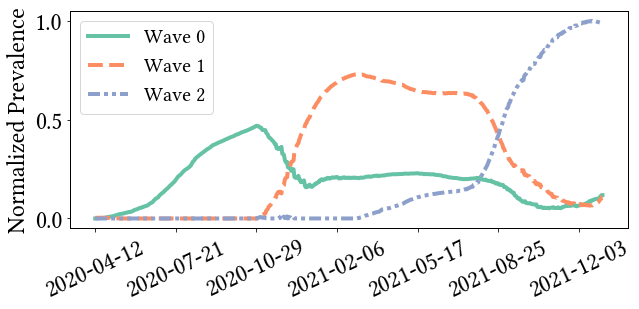

In [34]:
cX.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(cX.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 2")
plt.legend()

#cX.plot(figsize = (10,4))
plt.xticks(rotation = 25)
#plt.xlabel("Date")
plt.ylabel("Normalized Prevalence")
#plt.title("California Counties Diffusion NMF Columns of X")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/california_diffX2.pdf', bbox_inches = "tight")
plt.show()

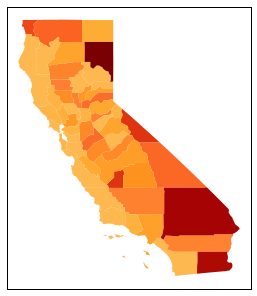

In [406]:
#plt.rcParams['font.size'] = 36

caliMap = gp.read_file(cali_map)
#cVK = cV@cK
#cVK.columns = cV.columns
row_num = 2

val_col1 = []
val_col2 = []
for i in caliMap["id"]:
    try:
        val_col1.append(cV.loc[row_num,int(i)])
    except:
        val_col1.append(np.nan)
'''      
for i in caliMap["id"]:
    try:
        val_col2.append(cVK.loc[row_num,int(i)])
    except:
        val_col2.append(np.nan)
'''

caliMap['val1'] = val_col1
#caliMap['val2'] = val_col2

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

caliMap.plot(column='val1',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax.set_title("Row " + str(row_num) + " of V")

'''
caliMap.plot(column='val2',legend=True, ax = ax[1], cmap='YlOrRd', legend_kwds={'shrink': 0.95, 'aspect': 40})
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax[1].set_title("Row " + str(row_num) + " of VK")
'''

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/california_V' + str(row_num) + '_2.pdf', bbox_inches = "tight")

In [408]:
# RE-order for better presentation
standard = [0,1,2]
reorder = [2,0,1]
cW = cW[reorder]
cW.columns = standard
cH = cH.reindex(reorder)
cH.index = standard 

In [35]:
#cW.to_csv("./testing_data/california_W.csv")
#cH.to_csv("./testing_data/california_H.csv")

'''
cW = pd.read_csv("./testing_data/california_W.csv", index_col = 0)
cH = pd.read_csv("./testing_data/california_H.csv", index_col = 0)
cH.columns = cH.columns.astype(int)
cW.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]
'''

#cW.to_csv("./testing_data/california_W2.csv")
#cH.to_csv("./testing_data/california_H2.csv")

cW = pd.read_csv("./testing_data/california_W2.csv", index_col = 0)
cH = pd.read_csv("./testing_data/california_H2.csv", index_col = 0)
cH.columns = cH.columns.astype(int)
cW.columns = ["Wave 0", "Wave 1", "Wave 2"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


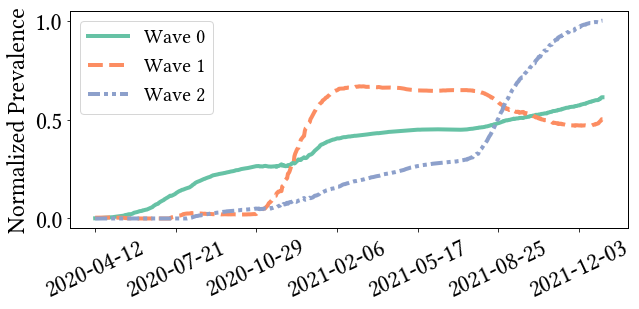

In [36]:
#fig,axs = plt.subplots(1,1,figsize = (10,5))
plt.rcParams['font.size'] = 24
cW.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(cW.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 2")
plt.ylabel("Normalized Prevalence")
plt.legend()
plt.xticks(rotation=25)
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/california_nmfX2.pdf', bbox_inches = "tight")
plt.show()

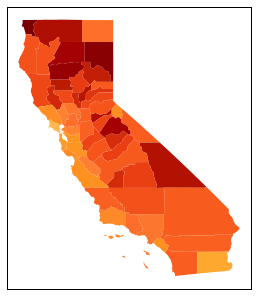

In [415]:
#plt.rcParams['font.size'] = 36

caliMap = gp.read_file(cali_map)
row_num = 2

val_col = []
for i in caliMap["id"]:
    try:
        val_col.append(cH.loc[row_num, int(i)])
    except:
        val_col.append(np.nan)


caliMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))
caliMap.plot(column='val', legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax.set_title("Row " + str(row_num) + " of H")
fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/california_H' + str(row_num) + '_2.pdf', bbox_inches = "tight")

In [49]:
california_diff_error = pd.read_csv("./testing_data/california_diff.csv", index_col = 0)
california_nmf_error = pd.read_csv("./testing_data/california_nmf.csv", index_col = 0)

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


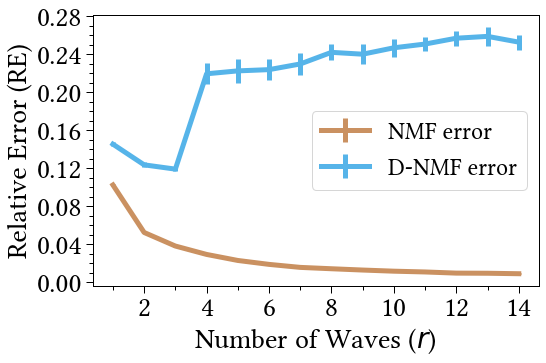

In [57]:
ranks = list(range(1,15))
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.04))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(ranks, california_nmf_error["relative error"], california_nmf_error["std error"], label = "NMF error", linewidth = 5, color = c_pal[5])
ax.errorbar(ranks, california_diff_error["relative error"], california_diff_error["std error"], label = "D-NMF error", linewidth = 5, color = c_pal[9])

ax.set_xlabel(r"Number of Waves ($r$)", fontsize = 28)
ax.set_ylabel("Relative Error (RE)", fontsize = 28)
plt.legend()
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/california_error.pdf', bbox_inches = "tight")

### World Level

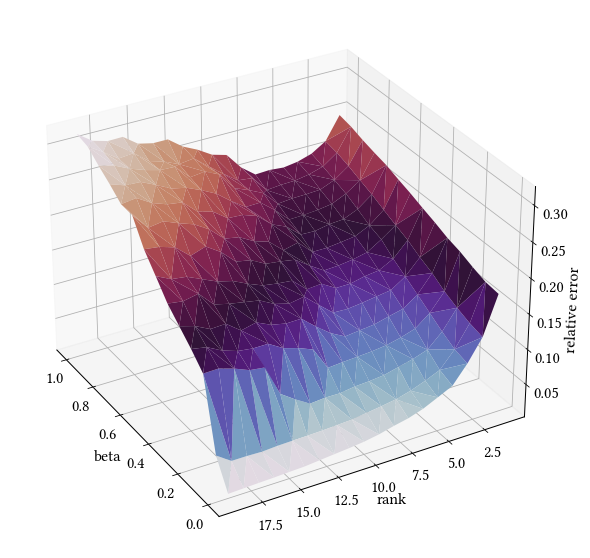

In [209]:
world_grid = pd.read_csv("./testing_data/covid_world_grid_search.csv")
world_grid = world_grid[world_grid["beta"] <= 1]
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(world_grid['beta'], world_grid['rank'], world_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

In [143]:
world_data = pd.read_csv(os.path.join(par, 'collected_data/world_dataset.csv'), index_col = 0)
world_laplacian = pd.read_csv(os.path.join(par, 'collected_data/worldLaplacian.csv'), index_col = 0).to_numpy()
# geo json map
world_map = os.path.join(par, 'collected_data/countries_geo.geojson')
world_population = pd.read_csv(os.path.join(par, 'collected_data/world_population.csv'), index_col = "Country")

In [273]:
world_data

,USA,RUS,JPN,IND,CHN,COL,MEX,BRA,UKR,PER,...,SDN,ZMB,TWN,BGR,SAU,HND,DZA,POL,URY,KHM
2020-04-12,555271,15770,6748,9205,83134,2776,4219,22192,2777,7519,...,19,43,388,675,4462,393,1914,6674,480,122
2020-04-13,580526,18328,7370,10453,83213,2852,4661,23430,3102,9784,...,19,45,393,685,4934,397,1983,6934,480,122
2020-04-14,607220,21102,7645,11487,83306,2979,5014,25262,3372,10303,...,29,45,393,713,5369,407,2070,7202,483,122
2020-04-15,636538,24490,8100,12322,83356,3105,5399,28320,3764,11475,...,32,48,395,747,5862,419,2160,7582,492,122
2020-04-16,667773,27938,8626,13430,83403,3233,5847,30425,4161,12491,...,32,48,395,800,6380,426,2268,7918,502,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,53170421,10258052,1731048,34808886,114365,5132277,3951946,22259270,3828336,2279299,...,46292,238383,16950,737233,553921,379402,217265,4064715,408894,120469
2021-12-29,53659688,10279009,1731446,34822040,114586,5138603,3956372,22269031,3833952,2279299,...,46518,243638,16964,740682,554665,379402,217647,4080282,410311,120473
2021-12-30,54246831,10299923,1731878,34838804,114794,5147039,3961662,22281649,3840041,2292254,...,46518,249193,16988,744298,555417,379402,218037,4094608,411658,120487
2021-12-31,54743982,10320405,1732296,34861579,115042,5157440,3979723,22291839,3847226,2292254,...,46518,254274,17029,747108,556236,379402,218432,4108215,413383,120493


In [211]:
# clean + normalize
world_dset = mat_opr(world_data)
world_iso = world_dset.iso()
pop_dict = {}
for col in world_iso.dataframe.columns:
    pop_dict[col] = world_population.loc[col,'Population']
    
world_norm = world_iso.population_normalizer(pop_dict)
world_norm = world_norm.dataframe

In [216]:
rank = 7
beta = 0.1
wK = np.linalg.inv(np.identity(len(world_laplacian)) + beta * world_laplacian)
dNMF = diffusionNMF(n_components = rank, kernel = wK, n_iter = 100000, tol = 1e-9)
wX,wV = dNMF.fit_transform(world_norm)

Max iterations reached, increase to converge on given tolerance


In [218]:
wX,wV = rescale(wX, wV)
wX = pd.DataFrame(wX, index = world_norm.index)
wV = pd.DataFrame(wV, columns = world_norm.columns)

In [221]:
# RE-order for better presentation
standard = [0,1,2,3,4,5,6]
reorder = [3,0,5,2,1,4,6]
wX = wX[reorder]
wX.columns = standard
wV = wV.reindex(reorder)
wV.index = standard 

In [135]:
#wX.to_csv("./testing_data/world_X.csv")
#wV.to_csv("./testing_data/world_V.csv")

wX = pd.read_csv("./testing_data/world_X.csv", index_col = 0)
wV = pd.read_csv("./testing_data/world_V.csv", index_col = 0)
wX.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4", "Wave 5", "Wave 6"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


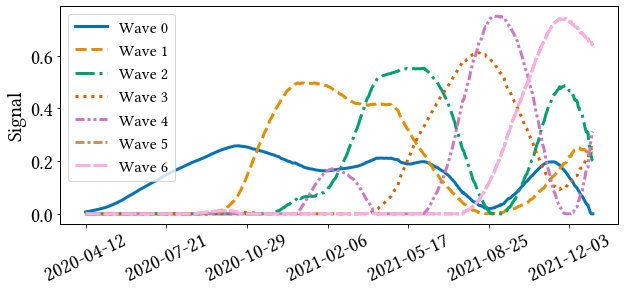

In [139]:
plt.rcParams['font.size'] = 20
#fig,axs = plt.subplots(1,1,figsize = (10,5))
wX.iloc[:,:-3].plot(figsize = (10,4), linewidth = 3, style = ['-', '--', '-.', ':'])
plt.plot(wX.iloc[:,-3], linewidth = 3, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.plot(wX.iloc[:,-2], linewidth = 3, linestyle = linestyles_dict["densely dashdotted"], label = "Wave 5")
plt.plot(wX.iloc[:,-2], linewidth = 3, linestyle = linestyles_dict["densely dashed"], label = "Wave 6")
plt.legend()
#wX.plot(figsize = (10,4), ax = axs)
#axs.tick_params(labelrotation=25)
plt.xticks(rotation = 25)
plt.ylabel("Signal")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/world_diffX.pdf', bbox_inches = "tight")
plt.show()

In [214]:
nmfer = nmf(rank, n_iter = 100000, tol = 1e-9)
wW,wH = nmfer.fit_transform(world_norm)

Max iterations reached, increase to converge on given tolerance


In [229]:
wW, wH = rescale(wW, wH)
wW = pd.DataFrame(wW, index = world_norm.index)
wH = pd.DataFrame(wH, columns = world_norm.columns)

In [231]:
# RE-order for better presentation
standard = [0,1,2,3,4,5,6]
reorder = [2,6,5,3,4,1,0]
wW = wW[reorder]
wW.columns = standard
wH = wH.reindex(reorder)
wH.index = standard 

In [140]:
#wW.to_csv("./testing_data/world_W.csv")
#wH.to_csv("./testing_data/world_H.csv")

wW = pd.read_csv("./testing_data/world_W.csv", index_col = 0)
wH = pd.read_csv("./testing_data/world_H.csv", index_col = 0)
wW.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4", "Wave 5", "Wave 6"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


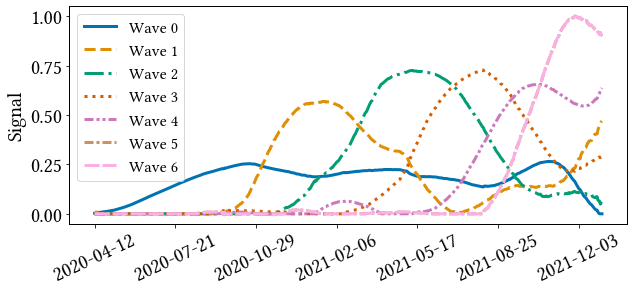

In [141]:
plt.rcParams['font.size'] = 20
#fig,axs = plt.subplots(1,1,figsize = (10,5))
wW.iloc[:,:-3].plot(figsize = (10,4), linewidth = 3, style = ['-', '--', '-.', ':'])
plt.plot(wW.iloc[:,-3], linewidth = 3, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.plot(wW.iloc[:,-2], linewidth = 3, linestyle = linestyles_dict["densely dashdotted"], label = "Wave 5")
plt.plot(wW.iloc[:,-2], linewidth = 3, linestyle = linestyles_dict["densely dashed"], label = "Wave 6")
plt.legend()
wW.plot(figsize = (10,4), ax = axs)
#axs.tick_params(labelrotation=25)
plt.xticks(rotation=25)
plt.ylabel("Signal")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/world_nmfX.pdf', bbox_inches = "tight")
plt.show()

In [235]:
world_diff_error = np.linalg.norm(world_norm - np.dot(wX, np.dot(wV, wK)))/np.linalg.norm(world_norm)
world_nmf_error = np.linalg.norm(world_norm - np.dot(wW, wH))/np.linalg.norm(world_norm)

print("Diffusion NMF error: " + str(world_diff_error))
print("NMF error: " + str(world_nmf_error))

Diffusion NMF error: 0.04859966814301027
NMF error: 0.03039429484052805


'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


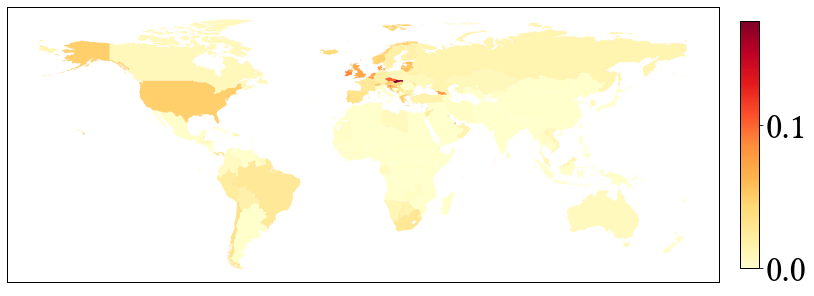

In [154]:
plt.rcParams["font.size"] = 36
worldMap = gp.read_file(world_map)
row_num = 6

val_col1 = []
for i in worldMap["ISO_A3"]:
    try:
        val_col1.append(wV.loc[row_num,i])
    except:
        val_col1.append(np.nan)


worldMap['val1'] = val_col1


fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (12,4))

worldMap.plot(column='val1',legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/world_V' + str(row_num) + '.pdf', bbox_inches = "tight")

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


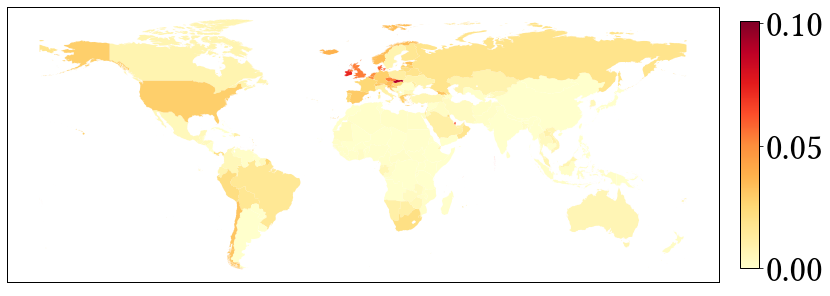

In [161]:
worldMap = gp.read_file(world_map)
row_num = 6

val_col1 = []
for i in worldMap["ISO_A3"]:
    try:
        val_col1.append(wH.loc[row_num,i])
    except:
        val_col1.append(np.nan)


worldMap['val1'] = val_col1


fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (12,4))

worldMap.plot(column='val1',legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/world_H' + str(row_num) + '.pdf', bbox_inches = "tight")

## Europe

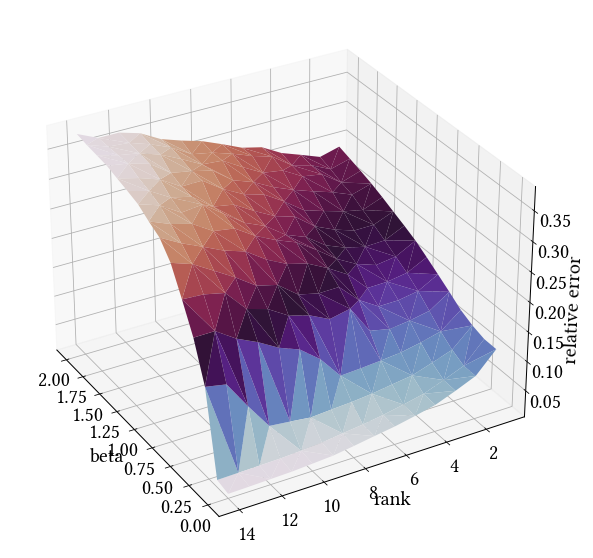

In [239]:
eur_grid = pd.read_csv("./testing_data/europe_grid2.csv")
eur_grid = eur_grid[eur_grid["beta"] <= 2]
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(eur_grid['beta'], eur_grid['rank'], eur_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

In [241]:
eur_grid.head(10)

,rank,beta,relative error,std error
0,1,0.000000,0.114022,0.000958
1,1,0.142857,0.114498,0.001580
2,1,0.285714,0.121092,0.000957
3,1,0.428571,0.131082,0.001663
4,1,0.571429,0.145802,0.001072
5,1,0.714286,0.159741,0.002602
6,1,0.857143,0.173391,0.001954
7,1,1.000000,0.186293,0.002335
8,1,1.142857,0.196376,0.002835
9,1,1.285714,0.205610,0.002170


In [59]:
eu_countries = ['RUS', 'UKR', 'FRA', 'ESP', 'SWE', 'NOR', 'KAZ', 'DEU', 'FIN', 'POL', 'ITA', 'GBR', 'ROU', 'BLR', 'GRC', 'BGR', 'HUN', 'PRT', 'AUT', 
                'CZE', 'SRB', 'IRL', 'LTU', 'LVA', 'HRV', 'BIH', 'SVK', 'EST', 'DNK', 'CHE', 'NLD', 'MDA', 'BEL', 'ALB', 'MKD', 'TUR', 'SVN', 'MNE', 'KOS',
                'AZE', 'LUX', 'GEO', 'AND', 'MLT', 'LIE', 'SMR', 'MCO', 'CYP', 'ARM']

world_data = pd.read_csv(os.path.join(par, 'collected_data/world_dataset.csv'), index_col = 0)
europe_data = world_data[eu_countries]

eu_map = os.path.join(par, "collected_data/europe_geo.json")
eur_population = pd.read_csv(os.path.join(par, 'collected_data/world_population.csv'), index_col = "Country")
eur_population = eur_population.loc[eur_population.index.isin(eu_countries)]
eur_laplacian = pd.read_csv(os.path.join(par, 'collected_data/worldLaplacian.csv'), index_col = 0)
eur_laplacian = eur_laplacian.loc[eu_countries, eu_countries].to_numpy()

In [60]:
len(europe_data.columns)

49

In [61]:
eur_laplacian = pd.read_csv(os.path.join(par, 'collected_data/worldLaplacian.csv'), index_col = 0)
eur_laplacian = eur_laplacian.loc[eu_countries, eu_countries]

In [100]:
np.diag(eur_laplacian)

array([13.,  7.,  8.,  4.,  2.,  3.,  4.,  9.,  3.,  7.,  5.,  1.,  5.,
        5.,  4.,  5.,  7.,  1.,  8.,  4.,  8.,  1.,  4.,  4.,  5.,  3.,
        5.,  2.,  1.,  5.,  2.,  2.,  4.,  4.,  4.,  8.,  4.,  4.,  4.,
        5.,  3.,  4.,  2.,  0.,  2.,  1.,  1.,  0.,  4.])

In [70]:
for c in eur_laplacian.columns:
    if eur_laplacian.loc[c,c] == 0:
        print(c)

MLT
CYP


In [62]:
# clean + normalize
europe_dset = mat_opr(europe_data)
europe_iso = europe_dset.iso()
pop_dict = {}
for col in europe_iso.dataframe.columns:
    pop_dict[col] = eur_population.loc[col,'Population']
    
europe_norm = europe_iso.population_normalizer(pop_dict)
europe_norm = europe_norm.dataframe

In [64]:
rank = 4
beta = 0.5
eK = np.linalg.inv(np.identity(len(eur_laplacian)) + beta * eur_laplacian)
dNMF = diffusionNMF(n_components = rank, kernel = eK, n_iter = 200000, tol = 1e-10)
eX,eV = dNMF.fit_transform(europe_norm)

In [65]:
eX,eV = rescale(eX, eV)
eX = pd.DataFrame(eX, index = europe_norm.index)
eV = pd.DataFrame(eV, columns = europe_norm.columns)

In [69]:
# RE-order for better presentation
standard = [0,1,2,3]
reorder = [0,3,1,2]
eX = eX[reorder]
eX.columns = standard
eV = eV.reindex(reorder)
eV.index = standard 

In [71]:
eX.to_csv("./testing_data/europe_X.csv")
eV.to_csv("./testing_data/europe_V.csv")

eX = pd.read_csv("./testing_data/europe_X.csv", index_col = 0)
eV = pd.read_csv("./testing_data/europe_V.csv", index_col = 0)
eX.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


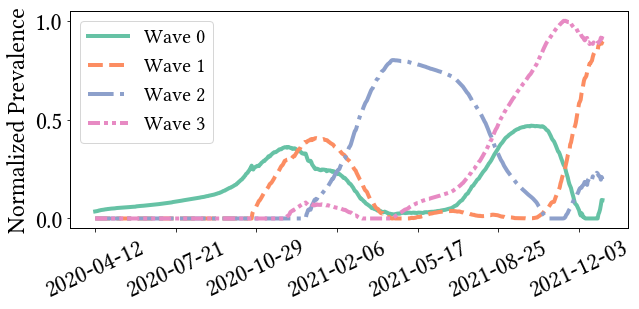

In [91]:
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 20
#fig,axs = plt.subplots(1,1,figsize = (10,5))
eX.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(eX.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 3")
#plt.plot(eX.iloc[:,-2], linewidth = 3, linestyle = linestyles_dict["densely dashdotted"], label = "Wave 5")
#plt.plot(eX.iloc[:,-2], linewidth = 3, linestyle = linestyles_dict["densely dashed"], label = "Wave 6")
plt.legend()
#wX.plot(figsize = (10,4), ax = axs)
#axs.tick_params(labelrotation=25)
plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalence")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/europe_diffX.pdf', bbox_inches = "tight")
plt.show()

In [66]:
nmfer = nmf(rank, n_iter = 200000, tol = 1e-10)
eW,eH = nmfer.fit_transform(europe_norm)

In [67]:
eW, eH = rescale(eW, eH)
eW = pd.DataFrame(eW, index = europe_norm.index)
eH = pd.DataFrame(eH, columns = europe_norm.columns)

In [74]:
# RE-order for better presentation
standard = [0,1,2,3]
reorder = [1,0,3,2]
eW = eW[reorder]
eW.columns = standard
eH = eH.reindex(reorder)
eH.index = standard 

In [76]:
eW.to_csv("./testing_data/europe_W.csv")
eH.to_csv("./testing_data/europe_H.csv")

eW = pd.read_csv("./testing_data/europe_W.csv", index_col = 0)
eH = pd.read_csv("./testing_data/europe_H.csv", index_col = 0)
eW.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


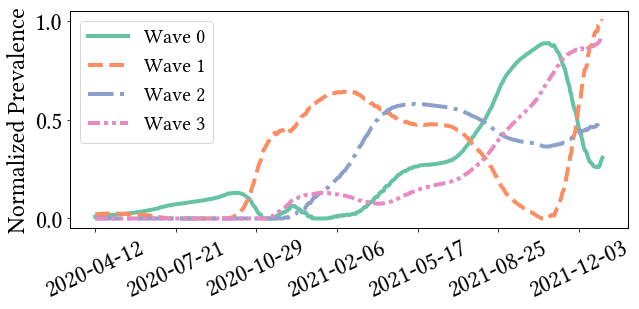

In [92]:
plt.rcParams['font.size'] = 24
#fig,axs = plt.subplots(1,1,figsize = (10,5))
eW.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(eW.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 3")
#plt.plot(eW.iloc[:,-2], linewidth = 3, linestyle = linestyles_dict["densely dashdotted"], label = "Wave 5")
#plt.plot(eW.iloc[:,-2], linewidth = 3, linestyle = linestyles_dict["densely dashed"], label = "Wave 6")
plt.legend()
#eW.plot(figsize = (10,4), ax = axs)
#axs.tick_params(labelrotation=25)
plt.xticks(rotation=25)
plt.ylabel("Normalized Prevalence")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/europe_nmfX.pdf', bbox_inches = "tight")
plt.show()

In [78]:
eur_diff_error = np.linalg.norm(europe_norm - np.dot(eX, np.dot(eV, eK)))/np.linalg.norm(europe_norm)
eur_nmf_error = np.linalg.norm(europe_norm - np.dot(eW, eH))/np.linalg.norm(europe_norm)

print("Diffusion NMF error: " + str(eur_diff_error))
print("NMF error: " + str(eur_nmf_error))

Diffusion NMF error: 0.0945836547167397
NMF error: 0.04484271007165099


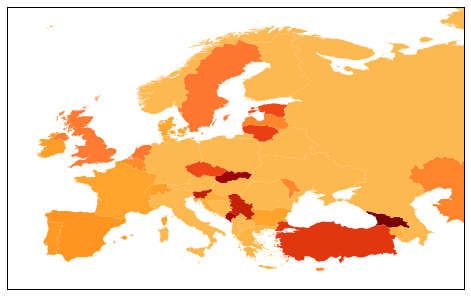

In [107]:
#plt.rcParams["font.size"] = 36
eurMap = gp.read_file(eu_map)
row_num = 3

val_col1 = []
for i in eurMap["ISO_A3"]:
    try:
        val_col1.append(eV.loc[row_num,i])
    except:
        val_col1.append(np.nan)


eurMap['val1'] = val_col1


fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

eurMap.plot(column='val1',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.set_xlim(-15, 55)
ax.set_ylim(32, 74)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper2/figures/europe_V' + str(row_num) + '.jpg', bbox_inches = "tight")

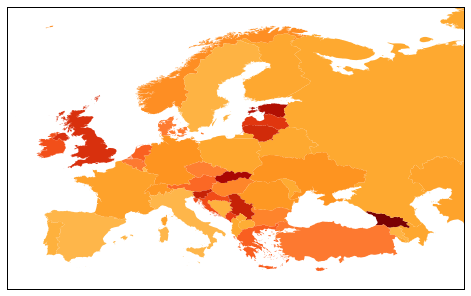

In [111]:
#plt.rcParams["font.size"] = 36
eurMap = gp.read_file(eu_map)
row_num =3

val_col1 = []
for i in eurMap["ISO_A3"]:
    try:
        val_col1.append(eH.loc[row_num,i])
    except:
        val_col1.append(np.nan)


eurMap['val1'] = val_col1


fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

eurMap.plot(column='val1',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.set_xlim(-15, 55)
ax.set_ylim(32, 74)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper2/figures/europe_H' + str(row_num) + '.jpg', bbox_inches = "tight")

In [51]:
europe_diff_error = pd.read_csv("./testing_data/europe_diff_error.csv", index_col = 0)
europe_nmf_error = pd.read_csv("./testing_data/europe_nmf_error.csv", index_col = 0)

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


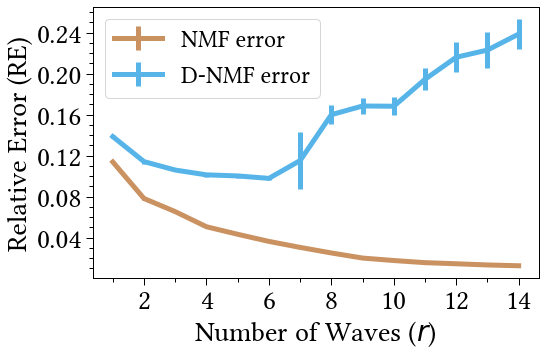

In [58]:
ranks = list(range(1,15))
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.04))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(ranks, europe_nmf_error["relative error"], europe_nmf_error["std error"], label = "NMF error", linewidth = 5, color = c_pal[5])
ax.errorbar(ranks, europe_diff_error["relative error"], europe_diff_error["std error"], label = "D-NMF error", linewidth = 5, color = c_pal[9])

ax.set_xlabel(r"Number of Waves ($r$)", fontsize = 28)
ax.set_ylabel("Relative Error (RE)", fontsize = 28)
plt.legend()
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/europe_error.pdf', bbox_inches = "tight")